# Introduction

Special thanks to
1. https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-full-cleaning
2. https://www.kaggle.com/cristophersfr/twitter-disaster-problem-with-pytorch
3. https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

And also, the official pytorch tutorial https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

for such wonderful kernels / documentation. I really learnt a lot from them. This analysis contains sample code from them, please check them out, and upvote (where applicable)


**NB: DO NOT BOTHER ABOUT THOSE WHO MADE PERFECT SCORES. THE LABELS ARE LEAKED ONLINE. JUST FOCUS ON LEARNING AND SHARING. There would always be other NLP competitions where you can use the skills you learn here**

# Imports and Data Reading

In [1]:
# Default kaggle imports

import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
# Useful imports necessary for our analysis

import torch
import torchtext
from torchtext import data
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data.utils import ngrams_iterator

import spacy # I'll be making use of spacy for text preprocessing
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string, re

from torch.autograd import Variable
import time
import copy
from torch.optim import lr_scheduler
from torch.utils.data.dataset import random_split

from sklearn.model_selection import train_test_split
from torchtext.vocab import Vectors, GloVe
from matplotlib.pyplot import plot, hist, xlabel, legend
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import logging
import warnings
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M:%S', level=logging.INFO)
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

train.drop_duplicates(subset=['text'], inplace=True)
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))
print('\n\tFirst five rows of our data:\n')
print(train.head())

Training Set Shape = (7503, 5)
Training Set Memory Usage = 0.34 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB

	First five rows of our data:

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


# Exploratory Data Analysis

1. Spot missing values, and make creative inferences from them.

### Missing Values

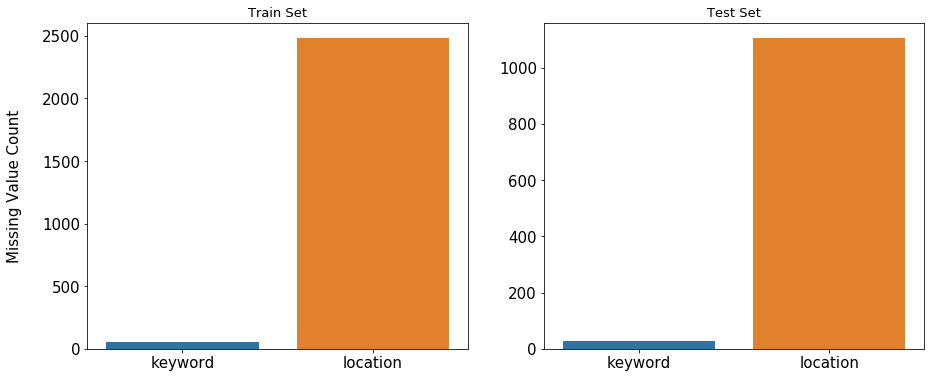

In [4]:
# probing the keyword and location columns
missing_cols = ['keyword', 'location']
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

sns.barplot(x=train[missing_cols].isnull().sum().index, y=train[missing_cols].isnull().sum().values, ax=ax[0])
sns.barplot(x=test[missing_cols].isnull().sum().index, y=test[missing_cols].isnull().sum().values, ax=ax[1])

ax[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

ax[0].set_title("Train Set", fontsize=13)
ax[1].set_title("Test Set", fontsize=13)

plt.show()

In [5]:
null_train = train.isnull().sum() * 100 / len(train)
null_test = test.isnull().sum() * 100/ len(test)

pd.concat([null_train, null_test], axis=1).rename(columns={0:'train missing %', 1:'test missing %'}).head()

,train missing %,test missing %
id,0.000000,0.000000
keyword,0.746368,0.796813
location,33.080101,33.864542
target,0.000000,NaN
text,0.000000,0.000000


we can see from above, the train and test set both have similar percentage of missing in keyword and location features. It would therefore be reasonable to infer that they were taken from the same source

In [6]:
# fill up all missing values
for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col].fillna(f'no_{col}', inplace=True)

### Cardinality & Target Distribution

Locations are not automatically generated, they are user inputs. This means that they were not automatically sent by the device using services like,*android location feature*, *gps*, *ip addresses* and others but a text field was created and the users typed in their location.
That's why location is very dirty and there are too many unique values in it. E.g. users in Nigeria could have put their location as: **Nigeria, 9ja, NGA**, e.t.c. This would cause their locations to be treated as different locations. It shouldn't be used as a feature.

Keywords are important because some words can only be used in one context. Keywords have different counts and target means. keyword can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on keyword.

In [7]:
print(f'Unique values in keyword = {train["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'Unique values in location = {train["location"].nunique()} (Training) - {test["location"].nunique()} (Test)')

Unique values in keyword = 222 (Training) - 222 (Test)
Unique values in location = 3328 (Training) - 1603 (Test)


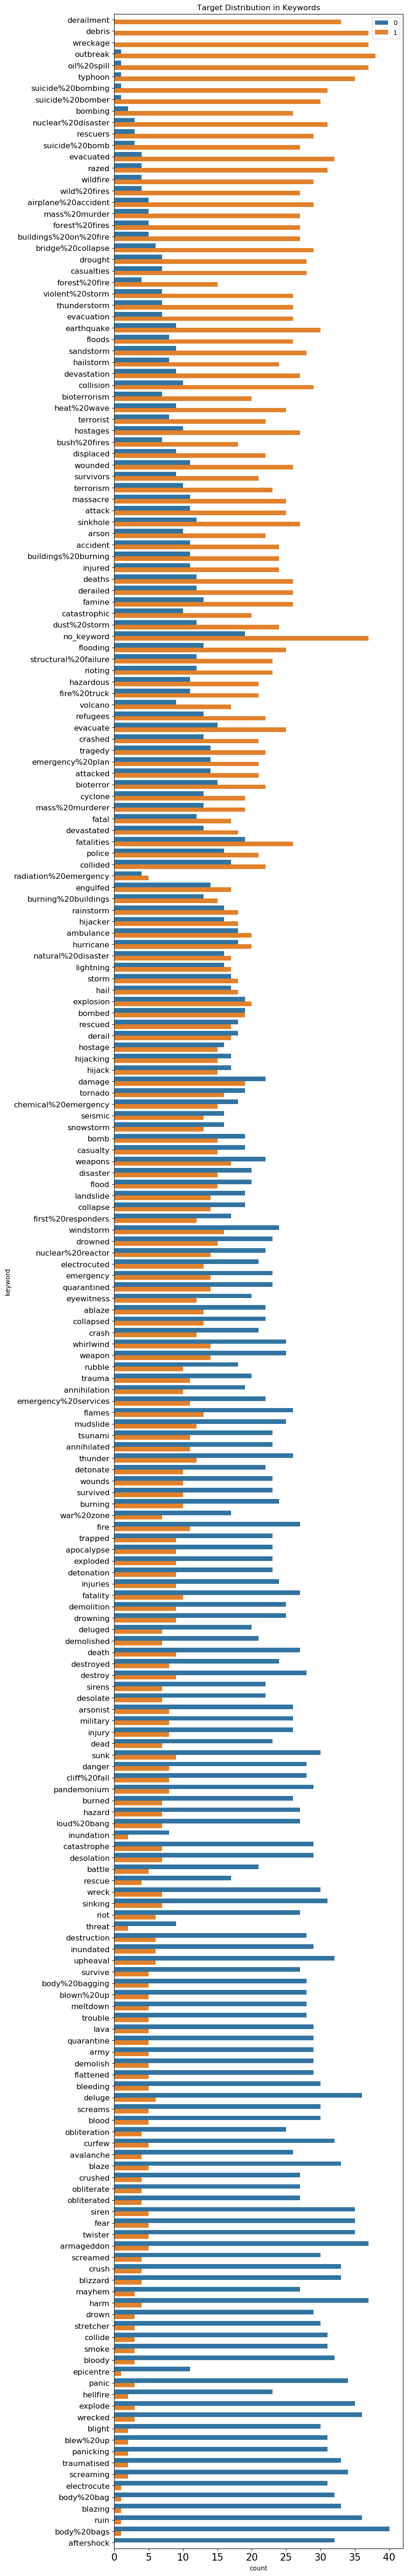

In [8]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

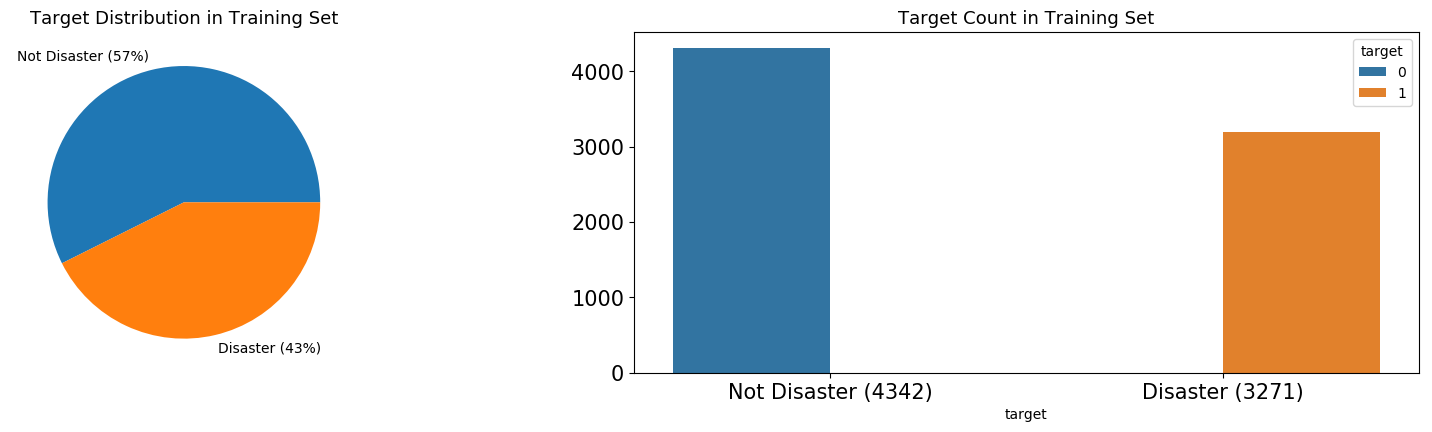

In [9]:
# viewing the distribution of the target variables

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

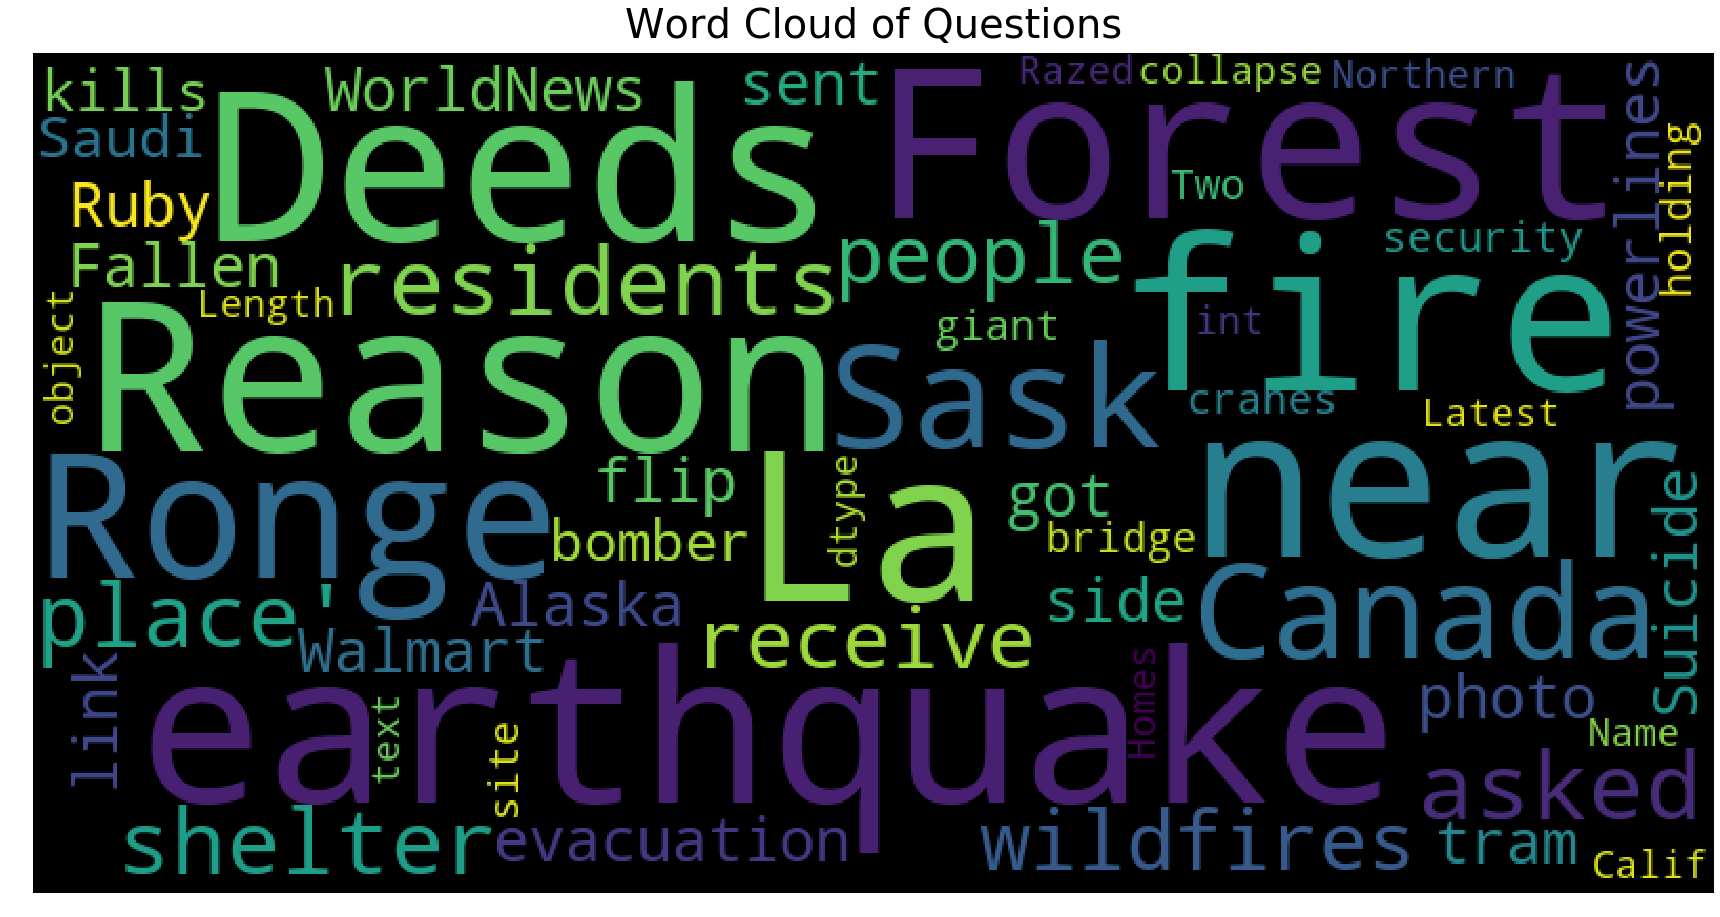

In [10]:
# viewing the word cloud to see most prominent words
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train["text"], title="Word Cloud of Questions")

### NGRAMS distribution

**Unigrams**

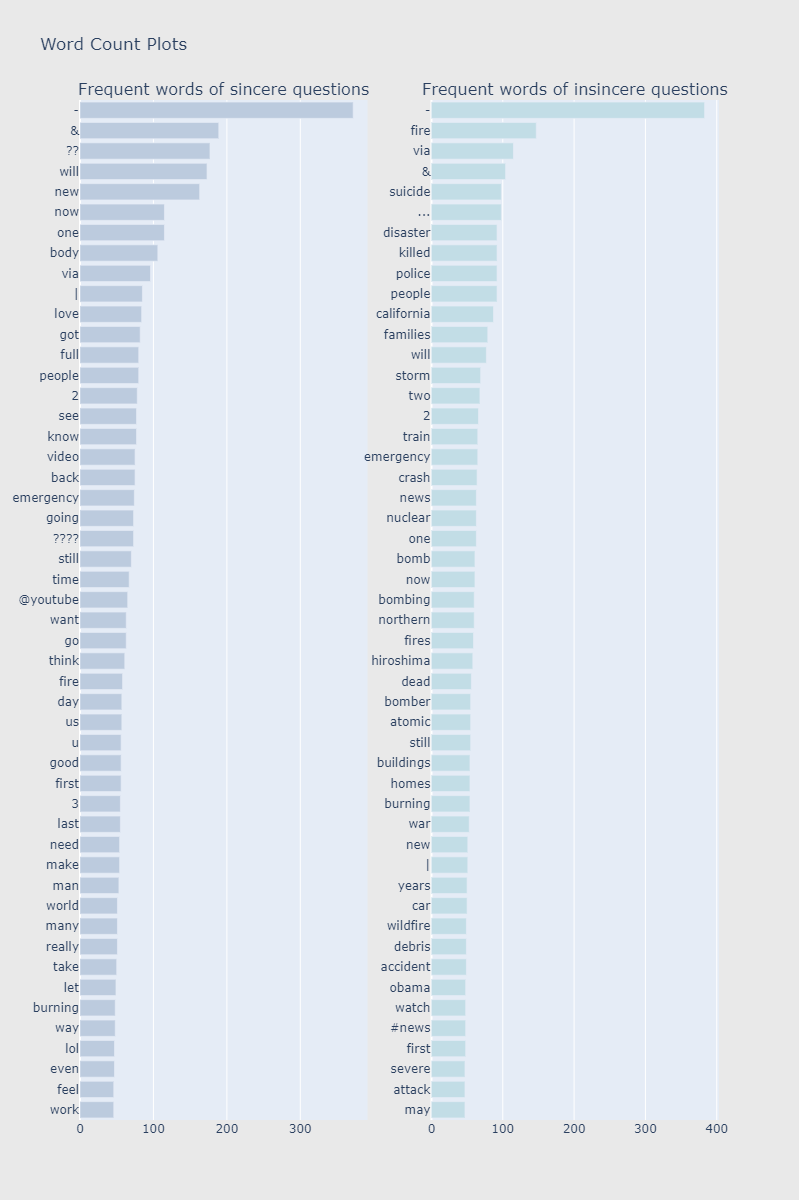

In [11]:
from collections import defaultdict
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), '#bccbde')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), '#c2dde6')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

**OBSERVATIONS**

1. Most common words that appear in both categories are very different.
2. Insincere questions tend to contain words that show violence or war.

**Bigrams**

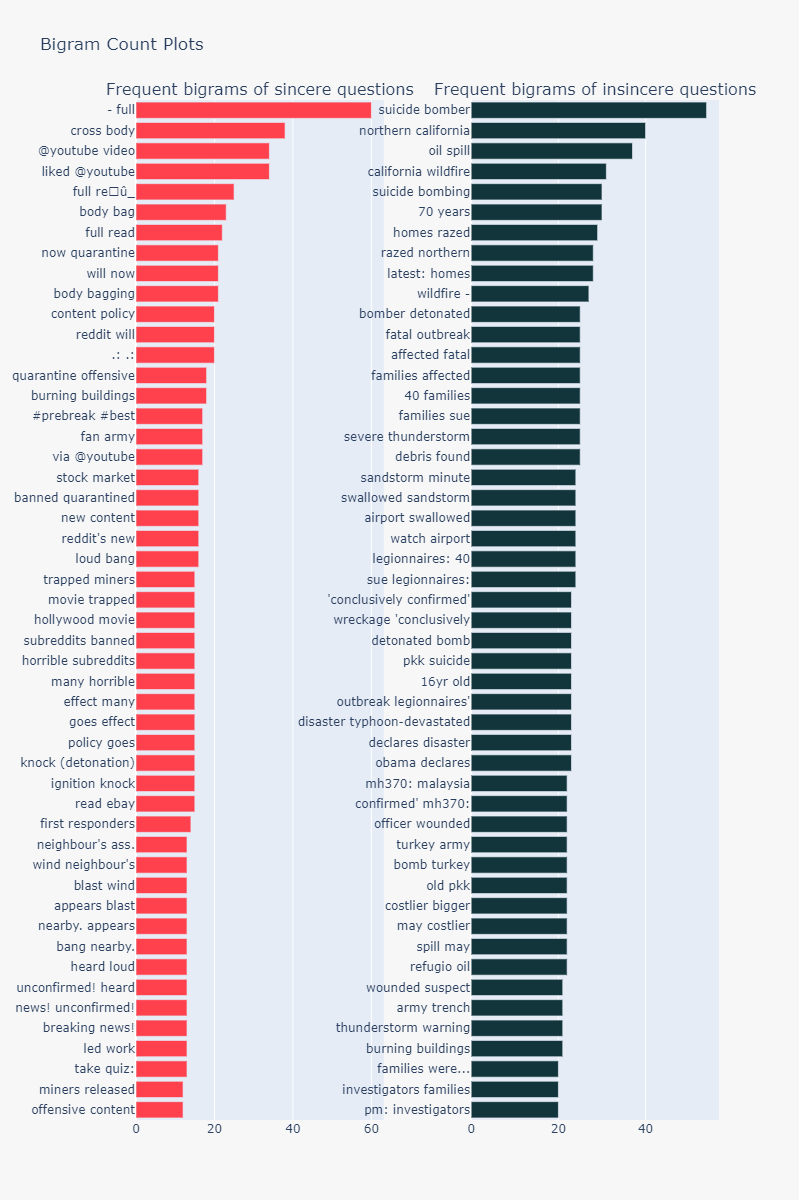

In [12]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), '#ff414e')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), '#12343b')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='#f7f7f7', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

**Trigrams**

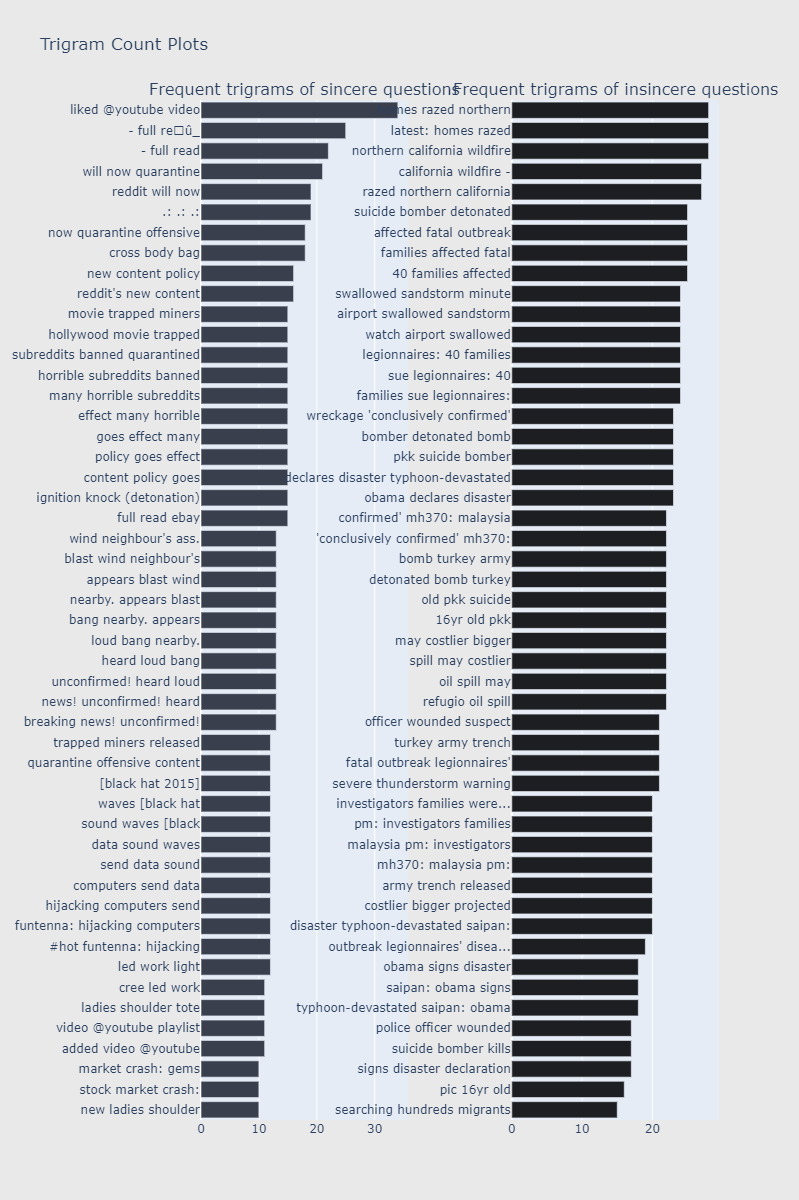

In [13]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), '#393f4d')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), '#1d1e22')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of sincere questions", 
                                          "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

# Model Building 

In [14]:
df_train = train['text']
df_test = test['text']

In [15]:
# Text preprocessing with spacy

def clean_text(text):
    return text.strip().lower()

punctuations = string.punctuation
nlp = spacy.load('en')
stop_words = STOP_WORDS
parser = English()

def spacy_preprocessor(sentence):
    """Tokenize, Lemmatize, Remove Stopwords"""
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    result = ' '.join(mytokens)
    return result

df_train = df_train.apply(lambda x: spacy_preprocessor(x))
df_test = df_test.apply(lambda x: spacy_preprocessor(x))

In [16]:
train['text'] = df_train
test['text'] = df_test

In [17]:
X = train[[col for col in train.columns if not col == 'target']]
y = train['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=20)

train_data = pd.concat([X_train, y_train], axis=1)
valid_data = pd.concat([X_valid, y_valid], axis=1)

# save them
!mkdir preprocessed_data
train_data.to_csv('preprocessed_data/train.csv', index=False)
valid_data.to_csv('preprocessed_data/valid.csv', index=False)
test.to_csv('preprocessed_data/test.csv', index=False)

In [18]:
is_cuda = torch.cuda.is_available()
print(f"Cuda Status on the system is {is_cuda}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cuda Status on the system is False


In [19]:
# choose a fixed length to process the string
fix_length = 17
text = data.Field(tokenize="spacy",
                  pad_first=True)

# define train, validation and test sets
train_data = data.TabularDataset(path="preprocessed_data/train.csv",
                                 format="csv",
                                 fields=[
                                         ('id', data.Field()),
                                         ('keyword', text),
                                         ('location', data.Field()),
                                         ('text', text),
                                         ('target', data.Field())],
                                 skip_header=True)

valid_data = data.TabularDataset(path="preprocessed_data/valid.csv",
                                 format="csv",
                                 fields=[
                                         ('id', data.Field()),
                                         ('keyword', text),
                                         ('location', data.Field()),
                                         ('text', text),
                                         ('target', data.Field())],
                                 skip_header=True)

test_data = data.TabularDataset(path="preprocessed_data/test.csv",
                                format="csv",
                                fields=[
                                        ('id', data.Field()),
                                        ('keyword', text),
                                        ('location', data.Field()),
                                        ('text', text),
                                        ],
                                skip_header=True)

text.build_vocab(train_data, valid_data)

In [20]:
VOCAB_SIZE = len(text.vocab)
NGRAMS = 2
BATCH_SIZE = 8
EMBED_DIM = 32
NUM_CLASS = 2

In [21]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        # initialize the weights
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [22]:
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUM_CLASS).to(device)

In [23]:
def generate_batch(batch):
    label = torch.tensor([int(entry.target[0]) for entry in batch])
    _text = []
    for entry in batch:
        _entry = []
        for t in entry.text:
            _entry.append(text.vocab.stoi[t])
        _text.append(torch.tensor(_entry,dtype=torch.long))
    offsets = [0] + [len(entry) for entry in _text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    _text = torch.cat(_text)
    return _text, offsets, label

In [24]:
def train_func(sub_train_):
    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    # Adjust the learning rate
    scheduler.step()
    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
    return loss / len(data_), acc / len(data_)

In [25]:
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_data) * 0.95)
sub_train_, sub_valid_ = random_split(train_data, [train_len, len(train_data) - train_len])

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)
    
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    
    print(f'Epoch: {epoch + 1}, | time in {mins} minutes and {secs} seconds')
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1, | time in 0.016666666666666666 minutes and 1 seconds
	Loss: 0.0767(train)	|	Acc: 65.8%(train)
	Loss: 0.0051(valid)	|	Acc: 74.1%(valid)
Epoch: 2, | time in 0.016666666666666666 minutes and 1 seconds
	Loss: 0.0533(train)	|	Acc: 81.2%(train)
	Loss: 0.0064(valid)	|	Acc: 76.1%(valid)
Epoch: 3, | time in 0.016666666666666666 minutes and 1 seconds
	Loss: 0.0365(train)	|	Acc: 88.1%(train)
	Loss: 0.0058(valid)	|	Acc: 78.1%(valid)
Epoch: 4, | time in 0.016666666666666666 minutes and 1 seconds
	Loss: 0.0239(train)	|	Acc: 93.2%(train)
	Loss: 0.0075(valid)	|	Acc: 79.7%(valid)
Epoch: 5, | time in 0.016666666666666666 minutes and 1 seconds
	Loss: 0.0153(train)	|	Acc: 96.3%(train)
	Loss: 0.0093(valid)	|	Acc: 76.4%(valid)


In [26]:
def predict(_text, model, vocab, ngrams):
    if len(_text) == 0:
        return 0
    with torch.no_grad():
        _text = [vocab.stoi[token] for token in ngrams_iterator(_text, ngrams)]
        output = model(torch.tensor(_text), torch.tensor([0]))
        return output.argmax(1).item()

model = model.to('cpu')
predictions = [predict(entry.text, model, text.vocab, NGRAMS) for entry in test_data]
tweet_id = [entry.id[0] for entry in test_data]

In [27]:
output = pd.DataFrame({'id': tweet_id, 'target': predictions})
output.to_csv('my_submission.csv', index=False)

In [28]:
output

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0
